In [1]:
%pwd 

'/workspaces/OpenDVCW'

In [2]:
# %cd /home/ubu-admin/Developer/tensorflow-wavelets
%cd /workspaces/OpenDVCW
from train import TrainOpenDVCW
import numpy as np
import load
import OpenDVCW
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import optimizers, losses 

import matplotlib.pyplot as plt
import flow_vis
import DataGen
import time
import datetime
import cv2

/workspaces/OpenDVCW


In [3]:
%load_ext tensorboard

In [4]:
def draw_flow(img, flow, step=12):

    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[0].numpy()[x,y].T

    lines = np.vstack([x, y, x-fx, y-fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)

    cv2.polylines(img, lines, 0, (0, 255, 0))

    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(img, (x1, y1), 1, (0, 255, 0), -1)

    return img


In [5]:
np_folder = "train_set_iqp27.npy"
BATCH_SIZE = 1
EPOCHS = 20
STEPS_PER_EPOCH = 10000
HEIGHT = 240
WIDTH = 240
CHANNLES = 3
NUM_FILTERS = 256
MV_KERNEL_SIZE=3
RES_KERNEL_SIZE=5
M=256
lmbda = 65536
lr_init = 1e-4
lr_alpha = 1e-8
early_stop = 2
I_QP=27
wavelet_name = "haar"
figsize = (20, 20)
template = 'Epoch {}, Loss Wavelet: {}, Loss DVC: {}'

In [6]:
data_gen = DataGen.DataVimeo90kGenerator(np_folder, 
                                            BATCH_SIZE,
                                            (HEIGHT, WIDTH, CHANNLES),
                                            CHANNLES,
                                            True, 
                                            I_QP,
                                            True,
                                            False)

inputs1 = tf.keras.Input(shape=(HEIGHT, WIDTH, CHANNLES,))
inputs2 = tf.keras.Input(shape=(HEIGHT, WIDTH, CHANNLES,))
loss_w, output_w = OpenDVCW.WaveletsOpticalFlow(BATCH_SIZE, HEIGHT, WIDTH, wavelet_name)([inputs1, inputs2])
loss, output = OpenDVCW.OpticalFlow(BATCH_SIZE, HEIGHT, WIDTH)([inputs1, inputs2])

model_w = tf.keras.Model([inputs1, inputs2], [loss_w, output_w])
model = tf.keras.Model([inputs1, inputs2], [loss, output])




2022-12-23 09:43:59.153331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 09:43:59.156784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 09:43:59.156879: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-23 09:43:59.157171: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:


current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir_w = 'logs/gradient_tape/' + wavelet_name + r"/" + current_time + '/train_w'
train_log_dir = 'logs/gradient_tape/' + wavelet_name + r"/" + current_time + '/train'
train_w_summary_writer = tf.summary.create_file_writer(train_log_dir_w)
train_summary_writer = tf.summary.create_file_writer(train_log_dir)

In [8]:
model_w.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 wavelets_optical_flow (Wavelet  ((),                240050      ['input_1[0][0]',                
 sOpticalFlow)                   (None, 240, 240, 2               'input_2[0][0]']            

In [9]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 240, 240, 3  0           []                               
                                )]                                                                
                                                                                                  
 optical_flow (OpticalFlow)     ((),                 240050      ['input_1[0][0]',                
                                 (1, 240, 240, 2))                'input_2[0][0]']          

Epoch 16, Loss Wavelet: 0.008474884554743767, Loss DVC: 0.008134843781590462


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


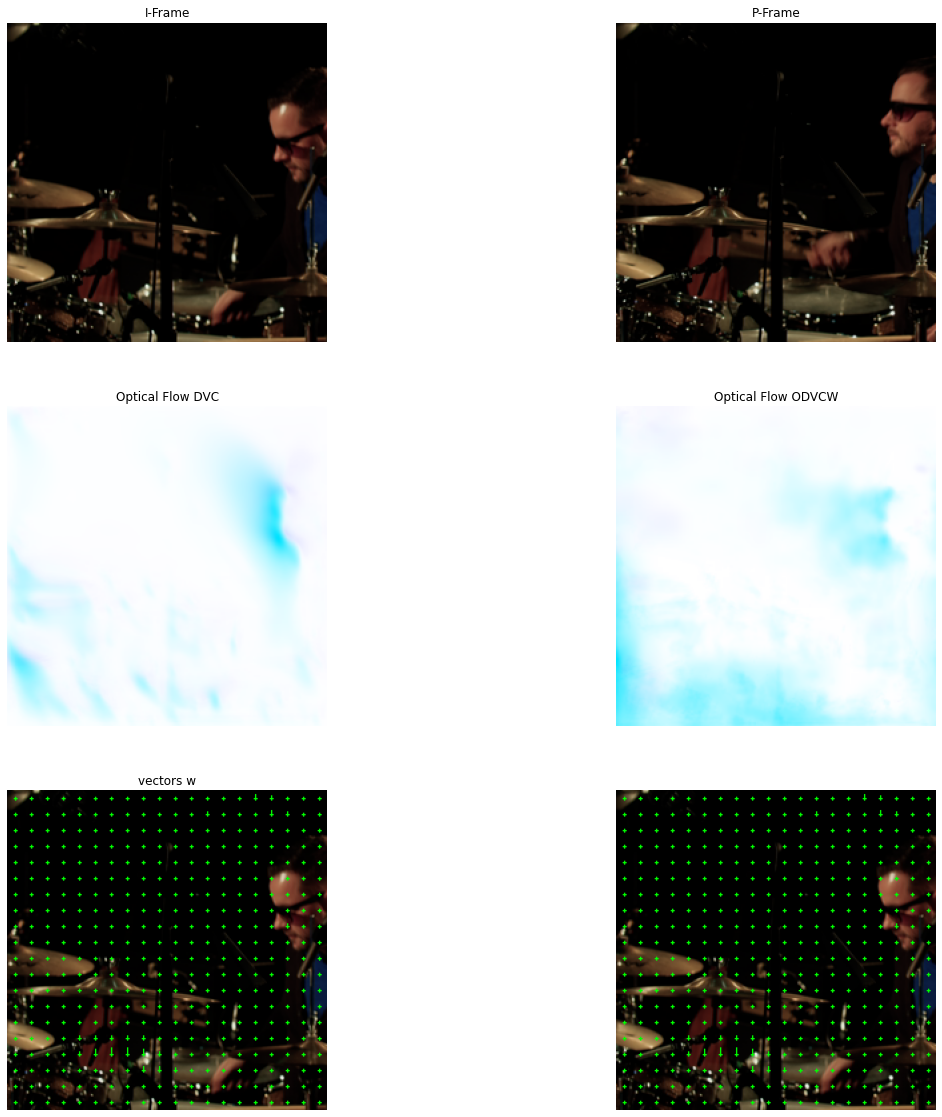

10/10 [==============================] - 2s 181ms/step - train_loss: 0.0098 - train_loss_w: 0.0099


In [10]:
from IPython.display import clear_output



metrics_names = ['train_loss_mse','train_loss_mse_w'] 
accuracy_names = ['train_accuracy', 'train_accuracy_w']

train_loss = tf.keras.metrics.Mean(metrics_names[0], dtype=tf.float32)
train_accuracy = tf.keras.metrics.MeanAbsoluteError(accuracy_names[0], dtype=tf.float32)
train_loss_w = tf.keras.metrics.Mean(metrics_names[1], dtype=tf.float32)
train_accuracy_w = tf.keras.metrics.MeanAbsoluteError(accuracy_names[1], dtype=tf.float32)


# Instantiate an optimizer.
optimizer_w = tf.keras.optimizers.Adam(learning_rate=lr_init)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_init)
num_of_training_samples = STEPS_PER_EPOCH
  
  
# Iterate over the batches of a dataset.
for epoch in range(EPOCHS):
    print("\nepoch {}/{}".format(epoch+1, EPOCHS))
    
    progBar = tf.keras.utils.Progbar(num_of_training_samples, stateful_metrics=metrics_names)
    cnt = 0
    for x, y in data_gen:

        # Open a GradientTape.
        with tf.GradientTape() as tape:
            # Forward pass.
            loss_value, logits = model(x, training=True)
            # Loss value for this batch.
        # Get gradients of loss wrt the weights.
        gradients = tape.gradient(loss_value, model.trainable_weights)
        # print(loss_value)
        # Update the weights of the model.
        optimizer.apply_gradients(zip(gradients, model.trainable_weights))
        train_loss(loss_value)
        # train_accuracy(x[0], logits)
        
        with tf.GradientTape() as tape_w:
            # Forward pass.
            loss_value_w, logits_w = model_w(x, training=True)
            # Loss value for this batch.
        # Get gradients of loss wrt the weights.
        gradients_w = tape_w.gradient(loss_value_w, model_w.trainable_weights)
        # print(loss_value)
        # Update the weights of the model.
        optimizer_w.apply_gradients(zip(gradients_w, model_w.trainable_weights))
        train_loss_w(loss_value_w)
        # train_accuracy(x[0], logits_w)
        
        
        values=[('train_loss',train_loss.result()), ('train_loss_w',train_loss_w.result())]
        progBar.update(cnt, values=values) 
        
        if cnt == STEPS_PER_EPOCH:
            break
        
        cnt += 1
            

    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=(epoch+1))
        
    with train_w_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss_w.result(), step=(epoch+1))
                
    clear_output(wait=True)  
    print(template.format(epoch+1,loss_value_w, loss_value))     
    fig, ax = plt.subplots(3, 2, figsize=figsize)
    flow = logits
    flow_color = flow_vis.flow_to_color(flow[0], convert_to_bgr=True)
    flow_w = logits_w
    flow_color_w = flow_vis.flow_to_color(flow_w[0], convert_to_bgr=True)
    
    gray_i = cv2.cvtColor(np.float32(x[0][0]), cv2.COLOR_BGR2GRAY)
    gray_p = cv2.cvtColor(np.float32(x[1][0]), cv2.COLOR_BGR2GRAY)
    flow_cv = cv2.calcOpticalFlowFarneback(gray_i, gray_p, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    flow_color_cv = flow_vis.flow_to_color(flow_cv, convert_to_bgr=True)

    ax[0, 0].imshow(x[0][0])
    ax[0, 0].axis('off')
    ax[0, 0].set_title("I-Frame")
    
    ax[0, 1].imshow(x[1][0])
    ax[0, 1].axis('off')
    ax[0, 1].set_title("P-Frame")
    
    ax[1, 0].imshow(flow_color)
    ax[1, 0].axis('off')
    ax[1, 0].set_title("Optical Flow DVC")
    
    ax[1, 1].imshow(flow_color_w)
    ax[1, 1].set_title("Optical Flow ODVCW")
    ax[1, 1].axis('off')
    
    ax[2, 0].imshow(draw_flow(x[0][0], flow))
    ax[2, 0].set_title("vectors")
    ax[2, 0].axis('off')
    
    ax[2, 1].imshow(draw_flow(x[0][0], flow_w))
    ax[2, 0].set_title("vectors w")
    ax[2, 1].axis('off')
    
    
    plt.show()
    progBar.update(num_of_training_samples, values=values, finalize=True)
    
    

In [ ]:
# gray_i = cv2.cvtColor(np.float32(x[0][0]), cv2.COLOR_BGR2GRAY)
# sample = 100
# i_f = np.float32(data_gen[sample][0][0][0])
# p_f = np.float32(data_gen[sample][0][1][0])

# gray_i = cv2.cvtColor(i_f, cv2.COLOR_BGR2GRAY)
# gray_p = cv2.cvtColor(p_f, cv2.COLOR_BGR2GRAY)
# flow = cv2.calcOpticalFlowFarneback(gray_i, gray_p, None, 0.5, 3, 15, 3, 5, 1.2, 0)
# flow_color = flow_vis.flow_to_color(flow, convert_to_bgr=True)
# fig, ax = plt.subplots(1, 3, figsize=figsize)
# ax[0].imshow(gray_i)
# ax[1].imshow(gray_p)
# ax[2].imshow(flow_color)
# # # End time
# # end = time.time()
# # # calculate the FPS for current frame detection
# fps = 1 / (end-start)

# print(f"{fps:.2f} FPS")

# cv2.imshow('flow', draw_flow(gray, flow))
# cv2.imshow('flow HSV', draw_hsv(flow))


In [ ]:
flow.shape